# Sonification: Convert data to MIDI (Part 2) 
This tutorial builds on part 1 by showing you how to map data to any parameter that can be automated in a digital audio workstation (DAW), such as stereo pan, pitch bend, or the cutoff frequency of a filter. This is done by writing *control change events* to a MIDI file and it opens up endless possibilities! We'll also develop fucntions that help streamline the general process. 

We'll work with two types of data. In section A we'll use the same lunar impact data used in part 1 [(Mazrouei et al 2019)](https://www.science.org/doi/10.1126/science.aar4058). It contains the positions of the 111 craters on the Moon that are larger than 10km across and have measured ages. We'll map the craters' longitude to time so that we are effectively sweeping around the Moon, hearing a note as we pass each crater. The pitch of the note will be used to communicate the latitude of the crater. As a simple first example, we'll add control change events to modify the stereo position of the sound.

In section B, we'll load an image of the Moon's entire surface to give a little introduction to working with image data. We'll use the average brightness of each column to control the pitch and cutoff frequency of a synth. You can use any data to control anything you like. Have fun! 

# Section A (crater data)
<br>
<div> <img src="figures/part2-mapping1.jpg" alt="Drawing" width="650"/></div>
<br>



## 0) Install required libraries (can skip if they're already installed)

In [ ]:
import sys
#install with pip 
!{sys.executable} -m pip install --quiet "pandas" "matplotlib" "audiolazy" "midiutil" "numpy" "Pillow"

#or use this if you installed python with anaconda
#conda install --yes --prefix {sys.prefix} pandas matplotlib audiolazy midiutil numpy Pillow

## 1) Load data (csv file)

In [1]:
import pandas as pd   #import library for loading data, https://pypi.org/project/pandas/

data_filename = 'lunarCraterAges'  #name of csv data file

df = pd.read_csv('./data/' + data_filename + '.csv')  #load data as a pandas dataframe
#df = df[(df['diameter'] >= 20)] #filter data if you like (for example, only craters larger than 20km)

df = df.sort_values(by=['longitude']) #sort data (optional, doesn't affect the sonification)

df.head() #take a look at first 5 rows
#df.tail() #take a look at last 5 rows

,names,longitude,latitude,diameter,age
100,Aratus,4.52681,23.57279,10.6,421
58,Egede A,10.50508,51.56250,13.0,84
25,Dionysius,17.29907,2.75990,18.7,492
95,Alfraganus C,18.08978,-6.12891,10.7,433
49,Nicolai A,23.58830,-42.46670,13.7,669


## 2) Plot data

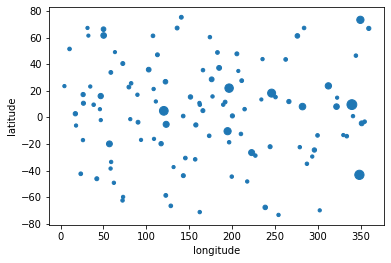

In [2]:
import matplotlib.pylab as plt  #import library for plotting, https://pypi.org/project/matplotlib/

longitudes = df['longitude'].values    #this is a numpy array (not a list), you can do mathematical operations directly on the object
latitudes = df['latitude'].values    
diameters = df['diameter'].values 

plt.scatter(longitudes, latitudes, s=diameters)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


## 3) Write general mapping function
This is a general mapping function that can take integers, floats, lists, or arrays as the input value. If you input a list/array, it will return a list/array. If both min_result and max_result are integers, it will return integer values, otherwise it will return floats. You can use a non-linear scaling by changing power to something other than 1. It also makes sure that the input value is within the input range.

In [3]:
import numpy as np  #import numerical python library, https://numpy.org/install/

def map_value(value, min_value, max_value, min_result, max_result, power=1):
    '''maps value(s) from one range to another

    value: input value (int, float, list, or array)
    min_value,max_value: input value range
    min_result,max_result: output value range
    power: scaling parameter, linear mapping if set to 1
    
    Returns:
        int if both min_result and max_result are int, otherwise float
        list of int or float if value is a list
        array of int or float if value is an array'''
    
    value_input = value 
    
    #if list, convert to array
    if isinstance(value_input, list): value = np.array(value_input) 
        
    #validation
    if np.any(value < min_value) or np.any(value > max_value):
        raise ValueError(f'one or more values is outside of range [{min_value},{max_value}]!')
            
    #mapping
    result = min_result + ((value - min_value)/(max_value - min_value))**power*(max_result - min_result)
    
    #rounding
    if isinstance(min_result*max_result, int):
        if isinstance(value_input, int) or isinstance(value_input, float):
            result = round(result)
        if isinstance(value_input, list) or isinstance(value_input, np.ndarray):
            result = np.round(result).astype(int)
    
    # value_input was list, convert result into list
    if isinstance(value_input, list): result = result.tolist() 
        
    return result

##testing
for value in [3, 3., [0,3,10], np.array([0,3,10])]:  #int, float, list , array
    result_float = map_value(value, 0, 10, 100., 200, power=1)
    result_int = map_value(value, 0, 10, 100, 200, power=1)
    print(result_float, type(result_float))
    print(result_int, type(result_int), '\n')

130.0 <class 'float'>
130 <class 'int'> 

130.0 <class 'float'>
130 <class 'int'> 

[100.0, 130.0, 200.0] <class 'list'>
[100, 130, 200] <class 'list'> 

[100. 130. 200.] <class 'numpy.ndarray'>
[100 130 200] <class 'numpy.ndarray'> 



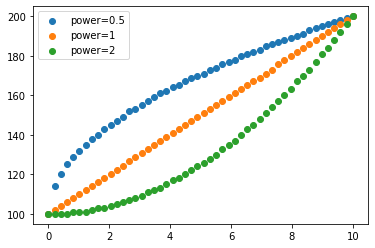

In [4]:
#testing power

x_test = np.linspace(0,10)

for power in [0.5, 1, 2]:
    y_test = map_value(x_test, 0, 10, 100, 200, power)
    
    plt.scatter(x_test,y_test,label='power='+str(power))
plt.legend()
plt.show()

## 5) Map longitude to time

In [5]:
degrees_per_beat = 4 #set conversion factor for time

duration = 360/degrees_per_beat
print('Duration:',duration,'beats')

bpm = 90  #if bpm = 60, 1 beat = 1 sec
sec_per_beat = 60/bpm 

duration_sec = duration*sec_per_beat
print('Duration:',duration_sec,'seconds')

Duration: 90.0 beats
Duration: 60.0 seconds


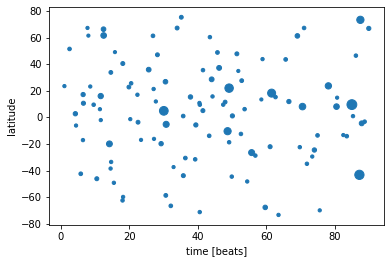

In [6]:


t_data =  map_value(longitudes, 0, 360, 0., duration) 

##to quantize the data to 16th notes (quarter of a beat), for example:
#t_data = np.round(t_data*4)/4

plt.scatter(t_data, latitudes, s=diameters)
plt.xlabel('time [beats]')
plt.ylabel('latitude')
plt.show()

## 6) Write function to get notes from a certain scale

In [7]:
from audiolazy import midi2str,str2midi

def get_scale_notes(start_note, octaves, scale):
    '''gets scale note names
    
    start_note: string , ex. 'C2'
    octaves: int, number of octaves
    scale: string (from available) or custom list of scale steps
    
    returns: list of note names (including root as highest note)
    '''
    
    scales = {
    'chromatic':[1,1,1,1,1,1,1,1,1,1,1,1],
        
    'major':[2,2,1,2,2,2,1],
    'minor':[2,1,2,2,1,2,2],
    'harmonicMinor':[2,1,2,2,1,3,1],
    'melodicMinor':[2,1,2,2,2,2,1],
        
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2],
        
    'majorPent':[2,2,3,2,3],
    'minorPent':[3,2,2,3,2],

    'wholetone':[2,2,2,2,2,2],
    'diminished':[2,1,2,1,2,1,2,1],
        
    #add more here!
    }
    
    #get scale steps 
    if type(scale) is str:
        if scale not in scales.keys():
            raise ValueError(f'Scale name not recognized!')
        else:
            scale_steps = scales[scale]
    if type(scale) is list:
        scale_steps = scale
        
    #get note names for each scale step, in each octave
    note_names = []
    for octave in range(octaves):
        note_number = str2midi(start_note) + (12*octave) 
        
        for step in scale_steps:
            note_names.append(midi2str(note_number))
            note_number = note_number + step
            
    #add root as last note
    last_midi_note = str2midi(start_note) + (octaves*12) 
    note_names.append(midi2str(last_midi_note))
    
    #could alter function to return midi note numbers instead
    #note_numbers = [str2midi(n) for n in note_names]
            
    return note_names

#note_names = get_scale_notes('C1', 3, 'lydian')
#note_names = get_scale_notes('C1', 3, [3,1,2,2,1,2]) #custom scale 
#print(note_names)

## 7) Map crater latitude to musical pitch, map diameter to note velocity

In [8]:
#choose note set 
note_names = get_scale_notes('C3', 3, 'lydian')
print(note_names)

note_numbers = np.array([str2midi(n) for n in note_names]) #make it an array so we can use do indexing on it with another array

print(note_numbers)


['C3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F#4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F#5', 'G5', 'A5', 'B5', 'C6']
[48 50 52 54 55 57 59 60 62 64 66 67 69 71 72 74 76 78 79 81 83 84]


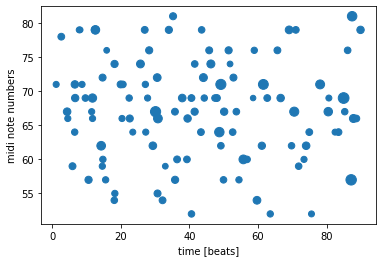

In [9]:


#map latitudes to midi note numbers 
midi_data = note_numbers[map_value(latitudes, -90, 90, 0, len(note_numbers)-1)] #map_value will return array of indices, corresponding to notes in note_numbers


#map diameters to note velocity
vel_min,vel_max = 30,115   #set minimum and maximum note velocity
vel_data = map_value(diameters, min(diameters), max(diameters), vel_min, vel_max, power=0.5)

plt.scatter(t_data, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

## 8) Save data as MIDI file
We'll organize the MIDI events as a list of dictionaries. Then we can feed this list to a function to save as a MIDI file. 

In [10]:

events = []
for i in range(len(t_data)):
    event = {}
    
    event['t'] = t_data[i]
    event['midi'] = midi_data[i]
    event['dur'] = 2
    event['vel'] = vel_data[i]
    events.append(event)
     

In [11]:
from midiutil import MIDIFile #import library to make midi file, https://midiutil.readthedocs.io/en/1.2.1/

def save_midi(events, out_filename, bpm=60):
    '''saves one track midi file with note events'''
    
    my_midi_file = MIDIFile(1) #one track 
    my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

    for event in events:
        my_midi_file.addNote(track=0, channel=0, pitch=event['midi'], time=event['t'] , duration=event['dur'], volume=event['vel'])

    with open(out_filename + '.mid', "wb") as f:
        my_midi_file.writeFile(f) 
    print('saved ' + out_filename + '.mid')
    
save_midi(events,'craters', bpm)

saved craters.mid


## 9) Map crater longitude to stereo pan using control changes
There are 128 different types of control change messages (1=modulation, 7=volume, 10=pan, 74=cutoff...). Each one's value can be set to integers from 0-127 (although some are binary, on for 0-63, off for 64-127). See the [full list of control change messages](https://anotherproducer.com/online-tools-for-musicians/midi-cc-list/).

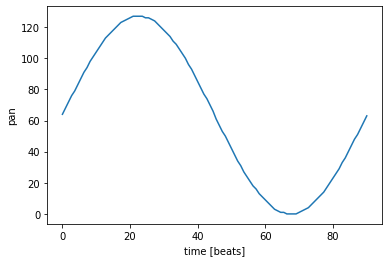

In [12]:

time_cc = np.linspace(0, duration, 100) #choose a time resolution for control change events

#simple left-to-right pan (same as mapping longitude to pan from left to right)
#pan_cc = map_value(time_cc, 0, duration, 0, 127)  #returns integers since 0 and 127 are integers

#more interesting example: sine wave pan (this follows the left-right position of craters as they sweep around the moon)
pan_sine = np.sin(2*np.pi*time_cc/duration)
pan_cc = map_value(pan_sine, -1, 1, 0, 127)

plt.plot(time_cc, pan_cc)
plt.xlabel('time [beats]')
plt.ylabel('pan')
plt.show()

## 10) Save as control change events

In [12]:

controller_number = 10 #pan = 10  

events_cc=[]
for i in range(len(time_cc)):
    events_cc.append({'t':time_cc[i],'controller_number':controller_number,'parameter':pan_cc[i]})
    

In [ ]:
def save_midi_cc(events, events_cc, out_filename, bpm=60):
    '''saves one track midi file with note events and control change events
    
    events: list of event dictionaries
    events_cc: list of control change event dictionaries
    out_filename: string, desired filename for mid file (_cc is appended)
    bpm: int or float, tempo in beats per minute'''
    
    my_midi_file = MIDIFile(1) #one track 
    my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

    for event in events:
        my_midi_file.addNote(track=0, channel=0, pitch=event['midi'], time=event['t'] , duration=event['dur'], volume=event['vel'])

    for event_cc in events_cc:
        my_midi_file.addControllerEvent(track=0, channel=0, time=event_cc['t'], controller_number=event_cc['controller_number'], parameter=event_cc['parameter'])

    with open(out_filename + '_cc.mid', "wb") as f:
        my_midi_file.writeFile(f) 
    print('saved ' + out_filename + '_cc.mid')
    
save_midi_cc(events,events_cc,'craters_pan', bpm=bpm)

# Section B (image data)

<br>
<div> <img src="figures/part2-mapping2.jpg" alt="Drawing" width="650"/></div>
<br>



## 1) Load image data
Greyscale digital images are stored as arrays of integers from 0-255, one for each pixel (with 0 being black, 255 being white). A colour image has thee numbers for each pixel, the levels of red, green, and blue. We will load a colour image and then convert it to greyscale since we're not using colour information (there isn't much anyway on the Moon's surface). 
<br>
<div> <img src="figures/pixel-data.png" alt="Pixel Data" width="650"/></div>
<br>

[image source](http://openframeworks.cc/ofBook/chapters/image_processing_computer_vision.html)

Image dimensions: 1024 512


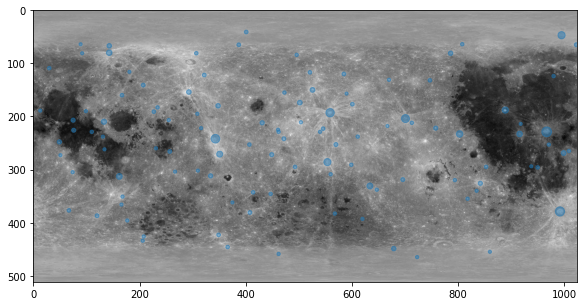

In [15]:
from PIL import Image #import library to load image

#moon texture map: https://svs.gsfc.nasa.gov/cgi-bin/details.cgi?aid=4720
image_filename = 'moon_surface'

im = Image.open('./data/'+ image_filename +'.jpg' )
width, height = im.size
print('Image dimensions:',width, height)

im_grey = im.convert('L') #convert to greyscale

im_grey = np.roll(im_grey, int(width/2)) #shift so that longitude=0 is at x=0 (left side), so that it matches the crater data

plt.figure( figsize=(10,5) )
plt.imshow(im_grey, cmap='gray')
#plt.scatter(longitudes,latitudes, s=diameters, alpha=0.5) #WRONG! Need to convert to pixel indexes
plt.scatter(map_value(longitudes, 0, 360, 0, width), map_value(latitudes, -90, 90, height, 0), s=diameters, alpha=0.5)


## 2) Plot the average brightness of each column

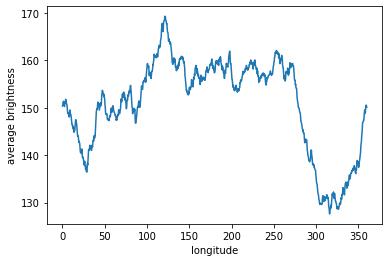

In [17]:

avg_brightness = np.mean(im_grey, axis=0) #average pixel value of each column

im_longitudes = np.linspace(0, 360, len(avg_brightness)) #array of each column's longitude (just for plotting)

plt.plot(im_longitudes, avg_brightness)
plt.xlabel('longitude')
plt.ylabel('average brightness')
plt.show()

## 3) Map average brightness to a control change parameter
We'll use a limited range for the CC value, centered around the midpoint, 63. 

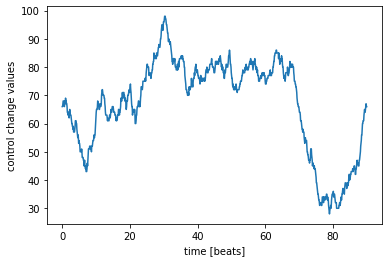

In [18]:

cc_min,cc_max = 63 - 35, 63 + 35 #limited CC range, centered around the midpoint 63

brightness_cc = map_value(avg_brightness, min(avg_brightness), max(avg_brightness), cc_min, cc_max )

time_cc_im = np.linspace(0, duration, len(brightness_cc)) #one time sample for each column

plt.plot(time_cc_im, brightness_cc)
plt.xlabel('time [beats]')
plt.ylabel('control change values')
plt.show()

## 4) Save CC events with a single long note 
We'll assign the CC events to control the pitch bend of a synth in a DAW.

In [19]:
events = [{'t': 0, 'midi': 60, 'vel': 100, 'dur': duration}] #make single long note

controller_number = 1 #modulation (this can be anything)

events_cc=[]
for i in range(len(time_cc_im)):
    events_cc.append({'t':time_cc_im[i], 'controller_number':controller_number, 'parameter':brightness_cc[i]})
    

save_midi_cc(events, events_cc, 'brightness_note', bpm=bpm)

saved brightness_note_cc.mid


## 5) Save CC events with a long chord 
We'll assign the CC events to control the cutoff frequency of a filter in a DAW.

In [20]:

chord_note_names=['C2','C3','G3','E4']  # C major chord
chord_note_numbers = [str2midi(c) for c in chord_note_names]

events=[]
for i in range(len(chord_note_numbers)):
    events.append({'t': 0, 'midi': chord_note_numbers[i], 'vel': 100, 'dur': duration})


controller_number = 74 # cutoff=74 (this can be anything)

events_cc=[]
for i in range(len(time_cc_im)):
    events_cc.append({'t':time_cc_im[i], 'controller_number':controller_number, 'parameter':brightness_cc[i]})

save_midi_cc(events, events_cc, 'brightness_chord', bpm=bpm)


saved brightness_chord_cc.mid


## Next Steps
- open MIDI file in a DAW (Logic, Abelton, Garageband,...)
- choose instruments/sounds
- assign control change automation to whatever you like